In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import h5py
import cv2

from ipywidgets import HBox, VBox, IntSlider, Dropdown, Play, jslink, HTML

from skimage.draw import polygon2mask
from skimage.measure import find_contours

%matplotlib widget

In [2]:
def mask_movie(movie, raw_mask, binning, flip=False):
    mask = cv2.resize(raw_mask, (0, 0), fx=1/binning, fy=1/binning,
                      interpolation=cv2.INTER_LINEAR)
    movie_size = movie.shape[1:3]
    mask = mask[:movie_size[0], :movie_size[1]].astype(bool)
    if flip:
        mask = np.flipud(mask)
    
    # Broadcast mask to movie shape
    mask = mask[None, :, :]  # if movie is (t, y, x)
    
    out = movie.astype(float).copy()
    out[:, ~mask[0]] = np.nan
    return out

def mask_region(movie, raw_outlines, binning, spaceorigin, flip=True):
    spaceorigin = (spaceorigin - 1) / binning + 1  # Apply space origin transformation

    # Extract all outlines and scale them according to binning
    outlines_nums = np.arange(raw_outlines.shape[2]) 
    outlines = raw_outlines[:, :, outlines_nums] / binning

    outlines[:, 0, :] -= spaceorigin[1] - 1  # Adjust Y-coordinates
    outlines[:, 1, :] -= spaceorigin[0] - 1  # Adjust X-coordinates

    # Define the movie dimensions
    movie_shape = movie.shape[1:3]  # (height, width)

    total_mask = np.zeros(movie_shape, dtype=bool)

    # Extract the ROI outline
    outline = outlines[37, :, :]  # Shape (2, N)

    valid_indices = ~np.isnan(outline).any(axis=0)  # Find non-NaN indices
    x_coords = outline[1, valid_indices]
    y_coords = outline[0, valid_indices]

    # Create a mask using polygon2mask
    roi_mask = polygon2mask(movie_shape, np.column_stack((y_coords, x_coords)))

    if flip:
        roi_mask = np.flipud(roi_mask).astype(bool)

    total_mask |= roi_mask  # Any pixel belonging to at least one ROI remains unmasked

    # Find contours of the ROI mask
    contours = find_contours(total_mask, level=0.5)  # Extract the outline

    return contours

def load_movie(mouse, date, file, denoised=True):
    if denoised:
        if mouse=='cfm001mjr' or mouse=='cfm002mjr':
            path = "N:/GEVI_Wave/Analysis/Visual/" + mouse + "/20" + str(date) + "/" + file + '/cG_unmixed_dFF_denoised_2.h5'
        else:
            path = "N:/GEVI_Wave/Analysis/Visual/" + mouse + "/20" + str(date) + "/" + file + '/cG_unmixed_dFF_denoised.h5'
    else:
        path = "N:/GEVI_Wave/Analysis/Visual/" + mouse + "/20" + str(date) + "/" + file + '/cG_unmixed_dFF.h5'

    with h5py.File(path, 'r') as mov_file:
        specs = mov_file["specs"]
        fps = specs['fps'][()].squeeze()
        raw_mask = specs["extra_specs"]["mask"][()].squeeze()
        binning = specs["binning"][()].squeeze()
        raw_outlines = specs["extra_specs"]["allenMapEdgeOutline"][()].squeeze()  
        spaceorigin = specs["spaceorigin"][()].squeeze()  

        mov = mov_file['mov'][10000:10200]
        movie = np.nan_to_num(mov)

        flip = False
        if mouse == 'cfm001mjr' or mouse == 'cfm002mjr' or mouse == 'cmm002mjr' or mouse == 'cmm003mjr' or mouse == 'rfm001mjr' or mouse == 'rfm002mjr' or mouse == 'rfm003mjr':
            flip = True

        if not denoised and flip:
            movie = np.flip(movie, axis=1) 

        if mouse == 'cfm003mjr' or mouse == 'cfm004mjr' or mouse == 'cmm001mjr':
            movie = np.flip(movie, axis=1)
            flip = True

        movie_masked = mask_movie(movie, raw_mask, binning, flip=flip)

        contours = mask_region(movie, raw_outlines, binning, spaceorigin, flip=True)
        
    return movie_masked, fps, contours

def load_recordings(mouse):
    trial_info_path = f"C:/Users/Katie/Documents/Katie/Code/perception_project/perception_project/trial_info/TrialInfo_{mouse}.csv"
    df = pd.read_csv(trial_info_path)
    unique_recordings = df[['AnimalCode', 'File', 'Date']].drop_duplicates() # Identify unique recordings
    print(f"Found {len(unique_recordings)} recordings.")

    clips_denoised = {}
    clips_noisy = {}
    outlines = {}

    i=1 # Counter for processing recordings
    # Load and process movies for each unique recording
    for _, row in unique_recordings.iterrows():
        mouse = row['AnimalCode']
        date = row['Date']
        file = row['File']
        
        try:
            clip_denoised, fps, _ = load_movie(mouse, date, file, denoised=True)
            clip_noisy, fps, contours = load_movie(mouse, date, file, denoised=False)
            clips_denoised[f'{mouse}/{date}/{file}'] = clip_denoised
            clips_noisy[f'{mouse}/{date}/{file}'] = clip_noisy
            outlines[f'{mouse}/{date}/{file}'] = contours

        except:
            print(f'Failed to load {mouse}/{date}{file}')

    return clips_denoised, clips_noisy, fps, outlines

In [3]:
def view_noisy_vs_denoised(clips_noisy, clips_denoised, outlines=None, fps=None, VMIN=-0.01, VMAX=0.01):
    """
    Interactive side-by-side viewer for noisy vs. denoised clips.
    If `outlines` is provided (dict keyed like the clips), draw each contour
    on top of the denoised image.

    Parameters
    ----------
    clips_noisy, clips_denoised : dict[str, np.ndarray]
        Each value is (t, y, x). Keys must match.
    outlines : dict[str, list[np.ndarray]] or None
        Optional dict: recording -> list of contours, each (N,2) in (y,x).
    fps : float or None
        If given, show time in seconds.
    VMIN, VMAX : float
        Fixed color limits for both images.
    """
    names = list(clips_noisy.keys())
    assert set(names) == set(clips_denoised.keys()), "Keys must match between noisy and denoised."

    k0 = names[0]
    t0 = clips_noisy[k0].shape[0]

    fig, ax = plt.subplots(1, 2, figsize=(8.5, 4.2), constrained_layout=True)
    for a in ax:
        a.set_xticks([]); a.set_yticks([])
        a.set_title(k0)

    im_noisy = ax[0].imshow(clips_noisy[k0][0], cmap='seismic', vmin=VMIN, vmax=VMAX)
    im_deno  = ax[1].imshow(clips_denoised[k0][0], cmap='seismic', vmin=VMIN, vmax=VMAX)
    cbar0 = fig.colorbar(im_noisy, ax=ax[0], fraction=0.046)
    cbar1 = fig.colorbar(im_deno,  ax=ax[1], fraction=0.046)

    # Keep handles to overlay lines so we can clear them when switching clips
    overlay_lines = []

    def draw_outlines_on_ax1(key):
        # Remove any existing overlay lines
        nonlocal overlay_lines
        for ln in overlay_lines:
            try: ln.remove()
            except Exception: pass
        overlay_lines = []

        if outlines is None or key not in outlines or not outlines[key]:
            return

        # Ensure axes limits follow the image (origin='upper')
        ny, nx = clips_denoised[key].shape[1:3]
        ax[1].set_xlim(0, nx)
        ax[1].set_ylim(ny, 0)

        for contour in outlines[key]:
            # contour in (y, x); plot as (x, y)
            line, = ax[1].plot(contour[:, 1], contour[:, 0], color='red', linewidth=1.5)
            overlay_lines.append(line)

    draw_outlines_on_ax1(k0)

    # Widgets
    dd = Dropdown(options=[(k, k) for k in names], value=k0, description='Clip:', layout={'width': '320px'})
    slider = IntSlider(value=0, min=0, max=t0-1, description='Frame:', continuous_update=True)
    play = Play(value=0, min=0, max=t0-1, interval=int(1000/(fps or 30)))
    jslink((play, 'value'), (slider, 'value'))
    readout = HTML()

    def set_time(i):
        readout.value = (f"<span style='font-family:monospace'>t = {i/fps:.3f} s</span>"
                         if fps else f"<span style='font-family:monospace'>frame = {i}</span>")

    state = {'name': k0}

    def update_frame(_=None):
        i, k = slider.value, state['name']
        im_noisy.set_data(clips_noisy[k][i])
        im_deno.set_data(clips_denoised[k][i])
        set_time(i)
        fig.canvas.draw_idle()

    def update_clip(_=None):
        k = dd.value
        state['name'] = k

        # Titles
        ax[0].set_title(k); ax[1].set_title(k)

        # Resize slider/play if needed
        t = clips_noisy[k].shape[0]
        slider.max = t - 1
        play.max = t - 1
        if slider.value > slider.max:
            slider.value = 0  # triggers update_frame

        # Fixed vlims; refresh colorbars
        im_noisy.set_clim(vmin=VMIN, vmax=VMAX)
        im_deno.set_clim(vmin=VMIN, vmax=VMAX)
        cbar0.update_normal(im_noisy); cbar1.update_normal(im_deno)

        # Redraw overlays for this recording on the denoised panel
        draw_outlines_on_ax1(k)

        update_frame()

    slider.observe(update_frame, 'value')
    dd.observe(update_clip, 'value')

    ui = VBox([HBox([dd, play, slider, readout]), fig.canvas])
    update_frame()
    return ui

In [4]:
clips_denoised, clips_noisy, fps, outlines = load_recordings('rfm002mjr')

Found 8 recordings.
Failed to load rfm002mjr/231207meas00
Failed to load rfm002mjr/231207meas01


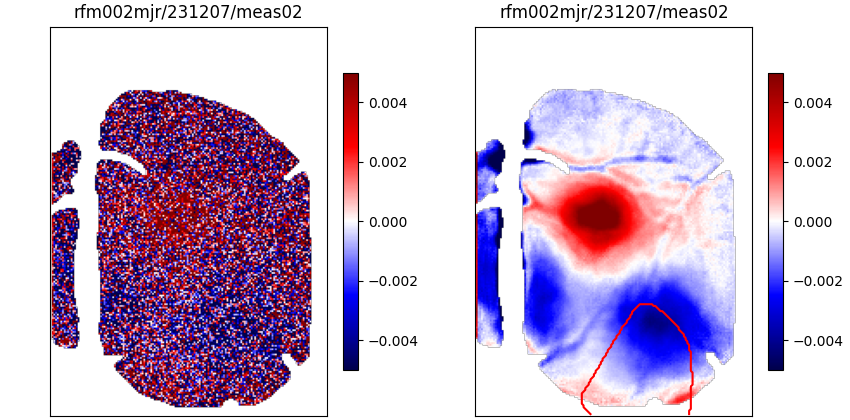

In [5]:
plt.close('all')
view_noisy_vs_denoised(clips_noisy, clips_denoised, outlines=outlines, fps=fps/2, VMIN=-0.005, VMAX=0.005)